In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%cd ..

/home/ubuntu/sustaingym


In [2]:
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})

from stable_baselines3 import PPO, A2C
from stable_baselines3.common.callbacks import EvalCallback, CallbackList
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.utils import set_random_seed
from stable_baselines3.common.vec_env import DummyVecEnv, SubprocVecEnv


from sustaingym.envs.evcharging import EVChargingEnv, GMMsTraceGenerator, RealTraceGenerator, RLAlgorithm, GreedyAlgorithm, RandomAlgorithm


In [17]:
# --exp 1   summer2019   ppo   discrete --seed 42
# --exp 2   summer2019   ppo   discrete --seed 43
# --exp 3   summer2019   ppo   discrete --seed 44
# --exp 4   summer2021   ppo   discrete --seed 42
# --exp 5   summer2021   ppo   discrete --seed 43
# --exp 6   summer2021   ppo   discrete --seed 44
# --exp 13   summer2019   a2c   discrete --seed 42
# --exp 14   summer2019   a2c   discrete --seed 43
# --exp 15   summer2019   a2c   discrete --seed 44
# --exp 16   summer2021   a2c   discrete --seed 42
# --exp 17   summer2021   a2c   discrete --seed 43
# --exp 18   summer2021   a2c   discrete --seed 44

groups = {
    ('summer2019', 'ppo'): [1, 2, 3],
    ('summer2021', 'ppo'): [4, 5, 6],
    ('summer2019', 'a2c'): [13, 14, 15],
    ('summer2021', 'a2c'): [16, 17, 18],
    ('summer2019', 'ppo', 'projection_while_training'): [101, 102, 103],
}


In [10]:
PATH_FORMAT = 'logs/exp_{num}/eval_on_eval_projected/best_model.zip'
TRAIN_DATE_PERIOD = 'Summer 2019'
TEST_DATE_PERIOD = 'Summer 2021'
SITE = 'caltech'
ACTION_TYPE = 'discrete'

EVAL_SEED = 100
NUM_TEST_RUNS = 123

def get_env(train=True, seed=106, action_type=ACTION_TYPE, project_action=False):
    date_period = TRAIN_DATE_PERIOD if train else TEST_DATE_PERIOD
    def _get_env():
        gen = GMMsTraceGenerator(site=SITE, date_period=date_period, random_seed=seed)
        return EVChargingEnv(gen, action_type=action_type, project_action=project_action)
    return _get_env

def get_exp_model(num):
    return PPO.load(PATH_FORMAT.format(num=num))

def training_results(group, train=False, projected=True):
    results = []
    for exp in groups[group]:
        fname = f'logs/exp_{exp}/eval_on_'
        if train:
            fname += 'train'
        else:
            fname += 'eval'
        if projected:
            fname += '_projected'
        fname += '/evaluations.npz'
        x = np.load(fname, allow_pickle=True)
        results.append(x['results'])

    timesteps = x['timesteps']
    results = np.hstack(results)
    y = results.mean(axis=1)
    error = results.std(axis=1)
    return timesteps, y, error


In [8]:
rl_models = {}
mean_rewards = {}
reward_components_sum = {}
for group in groups:
    for num in groups[group]:
        rl_models[num] = get_exp_model(num)


start = time.time()
for num in rl_models:
    print(f"experiment number: {num}, ", "seconds elapsed: ", time.time() - start)
    gen = RealTraceGenerator(SITE, date_period='Summer 2021', sequential=True)
    eval_env = EVChargingEnv(gen, action_type='discrete', project_action=True)
    # random seed values don't matter for sequential real trace generator
    alg = RLAlgorithm(rl_models[num], f'rl_alg_{num}')
    rewards, reward_components = alg.run([0 for _ in range(NUM_TEST_RUNS)], eval_env)
    mean_rewards[num] = np.array(rewards)
    reward_components_sum[num] = reward_components


gen = RealTraceGenerator(SITE, date_period='Summer 2021', sequential=True)
eval_env = EVChargingEnv(gen, action_type='discrete', project_action=True)
ga = GreedyAlgorithm()
offline_rewards, offline_reward_components = ga.run([0 for _ in range(NUM_TEST_RUNS)], eval_env)

experiment number: 1,  seconds elapsed:  0.00026607513427734375
experiment number: 2,  seconds elapsed:  522.565970659256
experiment number: 3,  seconds elapsed:  997.088235616684
experiment number: 4,  seconds elapsed:  1522.6065411567688
experiment number: 5,  seconds elapsed:  2007.5577368736267
experiment number: 6,  seconds elapsed:  2524.7588057518005
experiment number: 13,  seconds elapsed:  3001.6684436798096
experiment number: 14,  seconds elapsed:  3511.5429701805115
experiment number: 15,  seconds elapsed:  3997.8075561523438
experiment number: 16,  seconds elapsed:  4486.2791340351105
experiment number: 17,  seconds elapsed:  4990.061367988586
experiment number: 18,  seconds elapsed:  5469.260553598404


In [6]:
gen = RealTraceGenerator(SITE, date_period='Summer 2021', sequential=True)
eval_env = EVChargingEnv(gen, action_type='discrete', project_action=True)
ra = RandomAlgorithm()
random_rewards, random_reward_components = ra.run([0] * NUM_TEST_RUNS, eval_env)

In [17]:
import pickle

results = {}
with open('logs/test_results/results', 'wb') as f:
    results['mean_rewards'] = mean_rewards
    results['reward_components_sum'] = reward_components_sum
    results['offline_rewards'] = offline_rewards
    results['offline_reward_components'] = offline_reward_components
    pickle.dump(results, f)

In [11]:
import pickle

with open('logs/test_results/results', 'rb') as f:
    results = pickle.load(f)
    mean_rewards = results['mean_rewards']
    reward_components_sum = results['reward_components_sum']
    offline_rewards = results['offline_rewards']
    offline_reward_components = results['offline_reward_components']

In [12]:
group_stats = {}
for group in groups:
    best_exp, best_reward = 0, -10000000
    for exp_num in groups[group]:
        mean_reward = sum(mean_rewards[exp_num]) / len(mean_rewards[exp_num])
        if mean_reward > best_reward:
            best_exp, best_reward = exp_num, mean_reward

    group_mean = np.mean(mean_rewards[best_exp])
    group_std = np.std(mean_rewards[best_exp])
    group_stats[group] = best_exp, group_mean, group_std


In [13]:
offline_mean, offline_std = np.mean(offline_rewards), np.std(offline_rewards)

In [14]:
offline_rewards

[1.3564495667636065,
 0.0,
 3.141286912927645,
 12.094085873149732,
 7.812622759711338,
 4.165942797036604,
 9.400891056368629,
 1.5530666666666761,
 3.1423484197035143,
 5.761979712837652,
 6.185350118514333,
 12.008684760933903,
 4.859091994456074,
 10.625422726269873,
 3.568691189474037,
 5.208997307230834,
 3.844694853236532,
 6.632795665586044,
 12.26449352460957,
 4.840890033393025,
 6.93077738426408,
 2.741970252998089,
 2.3442542153303596,
 12.03472039943718,
 13.775777963644558,
 6.75187046044199,
 4.625884147028298,
 6.718952834454055,
 2.6690426084159453,
 1.511518597004321,
 1.2860382170615998,
 6.150799098374673,
 13.421135447720697,
 7.971369491277451,
 5.274809088908424,
 6.113309343747925,
 6.902753197389347,
 5.611859168427585,
 3.0236050050453973,
 9.159931910430602,
 6.36185354918409,
 11.093783932416581,
 4.078032249812466,
 2.171828595552785,
 10.559916040169384,
 9.409091039128988,
 6.347895419292771,
 9.627072575502137,
 13.202076103098944,
 9.108577081222263,
 1

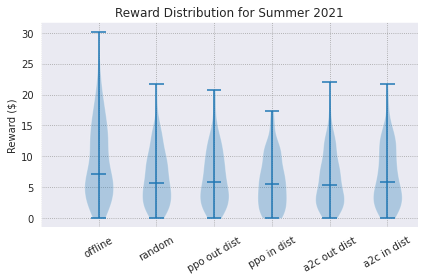

In [15]:
fig, ax = plt.subplots()

best_ood_ppo = mean_rewards[group_stats[('summer2021', 'ppo')][0]]
best_ind_ppo = mean_rewards[group_stats[('summer2019', 'ppo')][0]]
best_ood_a2c = mean_rewards[group_stats[('summer2021', 'a2c')][0]]
best_ind_a2c = mean_rewards[group_stats[('summer2019', 'a2c')][0]]
data = [offline_rewards, random_rewards, best_ood_ppo, best_ind_ppo, best_ood_a2c, best_ind_a2c]
labels = ['', 'offline', 'random', 'ppo out dist', 'ppo in dist', 'a2c out dist', 'a2c in dist']

ax.violinplot(data, showmedians=True)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Reward ($)')
ax.set_title('Reward Distribution for Summer 2021')
x = np.arange(len(labels))  # the label locations
ax.set_xticks(x, labels)
plt.xticks(rotation=30)

fig.tight_layout()

plt.savefig('algo_comp.png', dpi=300)
plt.show()


Text(0, 0.5, 'reward')

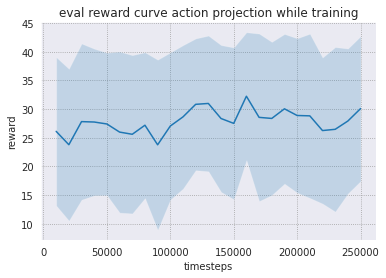

In [19]:
# experiments 101, 102, 103

timesteps, y, error = training_results(('summer2019', 'ppo', 'projection_while_training'), train=True)
plt.plot(timesteps, y)
plt.fill_between(timesteps, y-error, y+error, alpha=0.2)
plt.title('eval reward curve action projection while training')
plt.xlabel('timesteps')
plt.ylabel('reward')

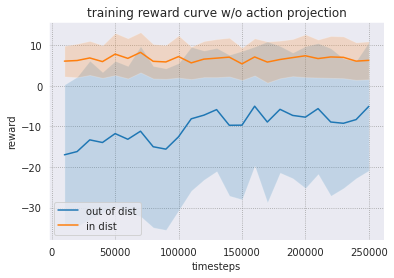

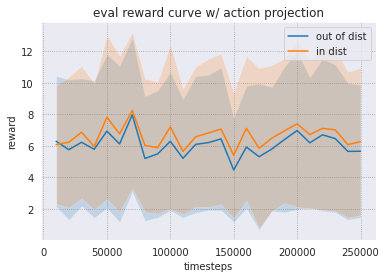

In [27]:
def plot_training_curve(title, projected, train):
    timesteps, y, error = training_results(('summer2019', 'ppo'), train=train, projected=projected)
    plt.plot(timesteps, y, label='out of dist')
    plt.fill_between(timesteps, y-error, y+error, alpha=0.2)

    timesteps, y, error = training_results(('summer2021', 'ppo'))
    plt.plot(timesteps, y, label='in dist')
    plt.fill_between(timesteps, y-error, y+error, alpha=0.2)

    plt.title(title)

    plt.ylabel('reward')
    plt.xlabel('timesteps')
    plt.legend()
    plt.show()


plot_training_curve('training reward curve w/o action projection', projected=False, train=True)
plot_training_curve('eval reward curve w/ action projection', projected=True, train=False)

In [28]:
group_stats

{('summer2019', 'ppo'): (2, 6.046858931518824, 4.341988150212312),
 ('summer2021', 'ppo'): (5, 6.8364148759433965, 4.696386454357062),
 ('summer2019', 'a2c'): (14, 6.968226395656997, 4.866659397136338),
 ('summer2021', 'a2c'): (16, 6.3021065360731106, 4.490703079499666)}

In [29]:
offline_reward_components

{'revenue': 1248.5124957329726,
 'carbon_cost': 105.45254257023979,
 'excess_charge': 0.0}

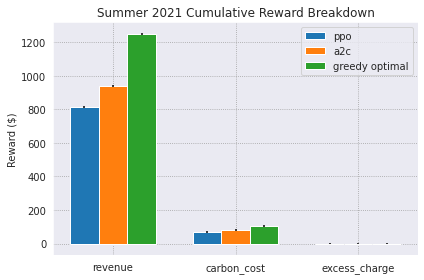

In [36]:
names = list(reward_components_sum[3].keys())

ppo_best_run = group_stats[('summer2019', 'ppo')][0]
ppo_values = list(reward_components_sum[ppo_best_run].values())

a2c_best_run = group_stats[('summer2019', 'a2c')][0]
a2c_values = list(reward_components_sum[a2c_best_run].values())

offline_values = list(offline_reward_components.values())

x = np.arange(len(names))  # the label locations
width = 0.35 * 2/3  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, ppo_values, width, label='ppo', yerr=in_dist_std, ecolor='black')
rects2 = ax.bar(x, a2c_values, width, label='a2c', yerr=out_dist_std, ecolor='black')
rects3 = ax.bar(x + width, offline_values, width, label='greedy optimal', yerr=out_dist_std, ecolor='black')

# Add some text for names, title and custom x-axis tick names, etc.
ax.set_ylabel('Reward ($)')
ax.set_title('Summer 2021 Cumulative Reward Breakdown')
ax.set_xticks(x, names)
ax.legend()

fig.tight_layout()

plt.show()